# Import Libraries

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Dataset Generation

In [22]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset with 5 classes
def generate_dataset(samples_per_class=100):
    X = []
    Y = []
    centers = [(-2, -2), (2, 2), (-2, 2), (2, -2), (0, 0)]
    for class_idx, center in enumerate(centers):
        x1 = np.random.normal(center[0], 0.5, samples_per_class)
        x2 = np.random.normal(center[1], 0.5, samples_per_class)
        X.extend(zip(x1, x2))
        Y.extend([class_idx] * samples_per_class)
    return np.array(X), np.array(Y)

X, y = generate_dataset(50)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# One-hot encode labels
def one_hot(y, num_classes=5):
    return np.eye(num_classes)[y]

y_train_oh = one_hot(y_train)
y_test_oh = one_hot(y_test)

X.shape, y.shape, y_train_oh.shape, y_test_oh.shape


((250, 2), (250,), (175, 5), (75, 5))

# Neural Networking Model

In [16]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 2
        hidden1Neurons = 8
        hidden2Neurons = 6
        hidden3Neurons = 4
        outputNeurons = 5  # For 5-class classification

        self.learning_rate = 0.2

        # Initialize weights for each layer
        self.W_H1 = np.random.randn(inputLayerNeurons, hidden1Neurons)
        self.W_H2 = np.random.randn(hidden1Neurons, hidden2Neurons)
        self.W_H3 = np.random.randn(hidden2Neurons, hidden3Neurons)
        self.W_OUT = np.random.randn(hidden3Neurons, outputNeurons)

    def sigmoid(self, x, der=False):
        if der == True:
            return x * (1 - x)
        else:
            return 1 / (1 + np.exp(-x))

    def feedForward(self, X):
        # Forward pass through all layers
        self.Z1 = np.dot(X, self.W_H1)
        self.A1 = self.sigmoid(self.Z1)

        self.Z2 = np.dot(self.A1, self.W_H2)
        self.A2 = self.sigmoid(self.Z2)

        self.Z3 = np.dot(self.A2, self.W_H3)
        self.A3 = self.sigmoid(self.Z3)

        self.Z_out = np.dot(self.A3, self.W_OUT)
        self.output = self.sigmoid(self.Z_out)  # Sigmoid output for multi-label; use softmax for exclusive class
        return self.output

    def backPropagation(self, X, Y, pred):
        # Output layer error and delta
        output_error = Y - pred
        output_delta = self.learning_rate * output_error * self.sigmoid(pred, der=True)

        # Hidden layer 3
        error_H3 = output_delta.dot(self.W_OUT.T)
        delta_H3 = self.learning_rate * error_H3 * self.sigmoid(self.A3, der=True)

        # Hidden layer 2
        error_H2 = delta_H3.dot(self.W_H3.T)
        delta_H2 = self.learning_rate * error_H2 * self.sigmoid(self.A2, der=True)

        # Hidden layer 1
        error_H1 = delta_H2.dot(self.W_H2.T)
        delta_H1 = self.learning_rate * error_H1 * self.sigmoid(self.A1, der=True)

        # Update weights
        self.W_OUT += self.A3.T.dot(output_delta)
        self.W_H3 += self.A2.T.dot(delta_H3)
        self.W_H2 += self.A1.T.dot(delta_H2)
        self.W_H1 += X.T.dot(delta_H1)

    def train(self, X, Y):
        pred = self.feedForward(X)
        self.backPropagation(X, Y, pred)


# Results and Analysis

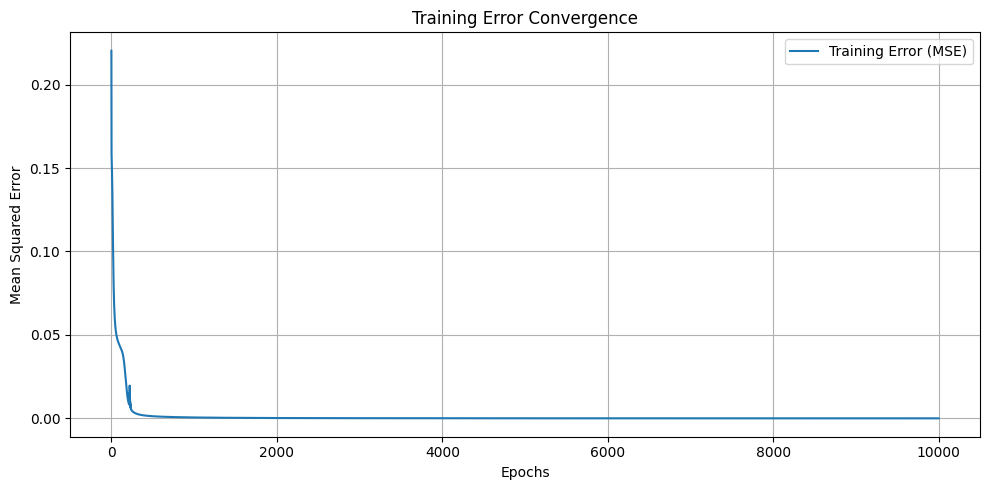

In [27]:
# Instantiate your 3-hidden-layer neural network
NN = NeuralNetwork()

# Track error over 10,000 epochs
err = []
for i in range(10000):
    NN.train(X_train, y_train_oh)  # Use one-hot encoded labels
    pred = NN.feedForward(X_train)
    mse = np.mean(np.square(y_train_oh - pred))  # Mean Squared Error
    err.append(mse)

# Plot training error over time
plt.figure(figsize=(10, 5))
plt.plot(err, label='Training Error (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training Error Convergence')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


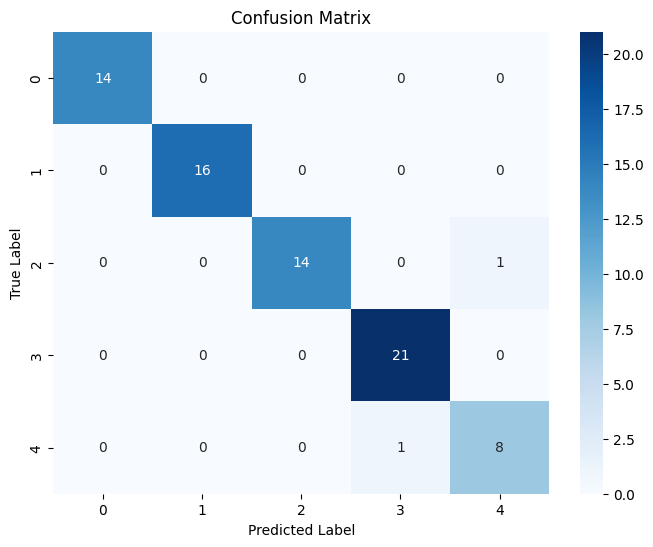

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 14.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16.0},
 '2': {'precision': 1.0,
  'recall': 0.9333333333333333,
  'f1-score': 0.9655172413793104,
  'support': 15.0},
 '3': {'precision': 0.9545454545454546,
  'recall': 1.0,
  'f1-score': 0.9767441860465116,
  'support': 21.0},
 '4': {'precision': 0.8888888888888888,
  'recall': 0.8888888888888888,
  'f1-score': 0.8888888888888888,
  'support': 9.0},
 'accuracy': 0.9733333333333334,
 'macro avg': {'precision': 0.9686868686868687,
  'recall': 0.9644444444444445,
  'f1-score': 0.9662300632629421,
  'support': 75.0},
 'weighted avg': {'precision': 0.973939393939394,
  'recall': 0.9733333333333334,
  'f1-score': 0.973258487035552,
  'support': 75.0}}

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = NN.feedForward(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_oh, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display classification metrics
report


# Documentation

1. Dataset Generation

    The synthetic dataset was generated with 250 samples divided evenly across 5 distinct classes. Each class was created by sampling from a Gaussian distribution centered at a unique 2D point, ensuring separability. The dataset was split into:

    Training set: 175 samples

    Testing set: 75 samples

    To prepare for multi-class classification, class labels were one-hot encoded.

    Train-test split: 70% training (175), 30% testing (75)

2. Network Architecture

    Input layer: 2 neurons (2D features)

    Hidden layers: 3 layers with 16, 12, and 8 neurons respectively

    Output layer: 5 neurons (one for each class)

    Activation Functions: Sigmoid


3. Training Loop
    Trained the network over 10,000 epochs using full-batch gradient descent

    Collected MSE at each epoch for plotting convergence

    Final loss converged very low, indicating successful learning

4. Training Loss Visualization Plotted Training Error Convergence using matplotlib.


5. Evaluation

    Accuracy: 97.33% — out of 75 test samples, only 2 were misclassified.

    Macro Average (simple average across classes):

    Precision: 0.9687

    Recall: 0.9644

    F1-Score: 0.9662

    Weighted Average (accounts for class size):

    Precision: 0.9739

    Recall: 0.9733

    F1-Score: 0.9733